In [1]:
import sys
sys.path.append('../input/timmmaster')
import timm

# Introduction:
* I have already Trained [Efficient Net Image Model](https://github.com/cr21/Shopee-Product-Matching/blob/main/notebooks/ArcfaceLoss%5Btraining%5D.ipynb) to generate Image Embeddings, I already stored trained Image embeddings to use it for downstreaming task.
* I also trained [Multilingual DistilBERT](https://github.com/cr21/Shopee-Product-Matching/blob/main/notebooks/shopee-bert-training.ipynb) Model to generate Text Embeddings
* I used [ArcFace Loss](https://arxiv.org/abs/1801.07698) to trained Image Model and Text Model to generate more discriminative embeddings.

# Better Decision Boundary
* We can calculate the probability that two products are matched based on their Image Embeddings cosine distance, and Text Embeddings cosine distance


### Load Libraries

In [2]:
# Preliminaries
from tqdm import tqdm
import math
import random
import os
import pandas as pd
import numpy as np



import gc
import matplotlib.pyplot as plt
import cudf
import cuml
import cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml import PCA
from cuml.neighbors import NearestNeighbors
import seaborn as sns


## Loading Data

In [3]:
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [4]:

image_embeddings = np.load('../input/multimodal-output/image_embeddings_0.9_training.npy')
print("Shape Of Image Embeddings", image_embeddings.shape)

Shape Of Image Embeddings (34250, 1536)


In [5]:

text_embeddings = np.load('../input/multimodal-output/Indonesian_distillbert_emebddings.npy')
print("Shape Of Text Embeddings", text_embeddings.shape)

Shape Of Text Embeddings (34250, 768)


In [6]:
def cross_validation_threshold(df, image_embeddings,text_embeddings, KNN = 50, metric_param = 'cosine'):
    print("image_embeddings shape",image_embeddings.shape)
    print("text_embeddings shape",text_embeddings.shape)
    # Fit KNN Model on Image Embeddings
    imagemodel = NearestNeighbors(n_neighbors = KNN,metric=metric_param)
    imagemodel.fit(image_embeddings)
    image_distances, image_indices = imagemodel.kneighbors(image_embeddings)
    
    ## Fit KNN Model on Text Embeddings
    textmodel = NearestNeighbors(n_neighbors = KNN,metric=metric_param)
    textmodel.fit(text_embeddings)
    text_distances, text_indices = textmodel.kneighbors(text_embeddings)
    
    # define text threshold for Cross validation
    text_thresholds = list(np.arange(0.1, 1, 0.1))
    # define Image threshold for Cross validation
    image_threshold = list(np.arange(0.1, 1, 0.1))
    scores = []
    image_params = []
    text_params = []
    
    # for each threshold get top k neighbors with in threshold distance 
    # then get f1 score
    
    for text_idx, txt_th in enumerate(text_thresholds[::-1]):
        print("**"*50)
        for img_idx, img_th in enumerate(image_threshold):
            predictions = []
            # get prediction with current text and image threshold 
            # get prediction matches 
            # and get f1 score
            
            for k in range(image_embeddings.shape[0]):
                # Image Predictions
                img_idx = np.where(image_distances[k,] < img_th)[0]
                image_ids = image_indices[k,img_idx]   
                # Text Predictions
                txt_idx = np.where(text_distances[k,] < txt_th)[0]
                text_ids = text_indices[k,txt_idx]
                
                # combine text and image predictions
                ids = np.concatenate([image_ids,text_ids])
                ids = np.unique(ids)
                
                # get posting ids based on retrival set
                posting_ids = ' '.join(df['posting_id'].iloc[ids].values)
                predictions.append(posting_ids)
                
            df['pred_matches'] = predictions
            df['f1'] = f1_score(df['matches'], df['pred_matches'])
            score = df['f1'].mean()
            print(f'Text threshold => {txt_th}  Image Threshold => {img_th}  F1 Score =>  {score}')
            scores.append(score)
            image_params.append(img_th)
            text_params.append(txt_th)
            
    # create dataframe for all the cross validation results
    thresholds_scores = pd.DataFrame({'img_thresholds': image_params, 'scores': scores,'text_thresholds':text_params})
    thresholds_scores.round({'img_thresholds': 2, 'text_thresholds': 2,'scores':2})
    return scores,image_params,text_params, thresholds_scores

In [7]:
def read_dataset():
    df = pd.read_csv('../input/shopee-product-matching/train.csv')
    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['matches'] = df['label_group'].map(tmp)
    df['matches'] = df['matches'].apply(lambda x: ' '.join(x))

    return df
df = read_dataset()


In [8]:

scores, img_params, txt_params, result_df = cross_validation_threshold(df, image_embeddings,text_embeddings, KNN = 50, metric_param = 'cosine')
    

image_embeddings shape (34250, 1536)
text_embeddings shape (34250, 768)
****************************************************************************************************
Text threshold => 0.9  Image Threshold => 0.1  F1 Score =>  0.18179834575743015
Text threshold => 0.9  Image Threshold => 0.2  F1 Score =>  0.18202434515628751
Text threshold => 0.9  Image Threshold => 0.30000000000000004  F1 Score =>  0.18219728461309875
Text threshold => 0.9  Image Threshold => 0.4  F1 Score =>  0.18237815431608884
Text threshold => 0.9  Image Threshold => 0.5  F1 Score =>  0.18258315407338335
Text threshold => 0.9  Image Threshold => 0.6  F1 Score =>  0.1825094794015059
Text threshold => 0.9  Image Threshold => 0.7000000000000001  F1 Score =>  0.18035818714923957
Text threshold => 0.9  Image Threshold => 0.8  F1 Score =>  0.15107097275306886
Text threshold => 0.9  Image Threshold => 0.9  F1 Score =>  0.11808008360356759
*****************************************************************************

# Plot Decision Boundry

In [9]:
def plot_decision_boundry(results):
    results = results.pivot('text_thresholds','img_thresholds','scores')
    results.columns = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    results.index = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    sns.set_theme()
    sns.set(rc={'figure.figsize':(14.7,11.27)})
    ax = sns.heatmap(results, annot=True,cmap="Blues",xticklabels=True,)
    ax.set_title('Probability That Two Products Match\n')
    ax.set(ylabel="Text Threshold",xlabel="Image Threshold")
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
    ax.xaxis.set_label_position('top')

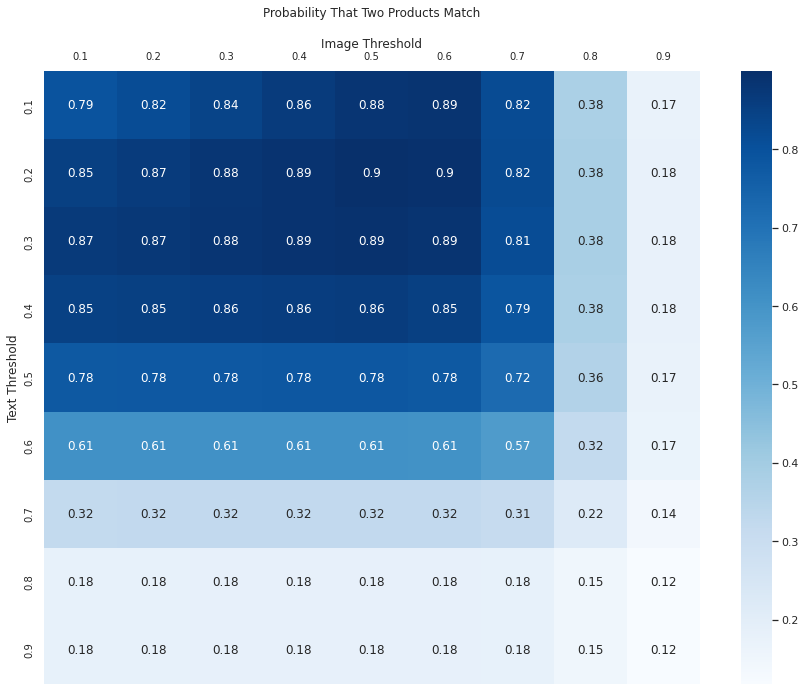

In [10]:
plot_decision_boundry(result_df)

# Observation

* From the plot above, we can infer following things 
* In **My submission** If **cosine Image distance <0.3** and **Text Distance < 0.17**, I consider them a **match**.
* Based on Plot we could increasing our matching, i.g. If two products have **cosine image distance <=0.6** and  **cosine text distance  <= 0.5** then we should consider them a **match**. 